# HACKtheMACHINE 2021 | Track 2: Data Science, Detective Bot 

The following data dictionary describes the columns or fields of the data set and a description of the objects. This information with more detail can also be found in the `EMBER` documentation of the `features.py` file at: https://github.com/elastic/ember/blob/master/ember/features.py 

| Field Name | Description | 
|------------|-------------|
| sha256 | The Secure Hash Algorithm (SHA) is a cryptographic hash function like a signature or fingerprints for a data set. Even if one symbol is changed the algorithm will produce a different hash value. The SHA256 algorithm generates a fixed size 256-bit (32-byte) hash. The SHA256 algorithm is used to ensure you acquire the same data as the original. For exmaple, if you download something you can check if the data has not changed (due to network errors or malware injection) by comparing the hashes of your file and the original.|
| histogram | Byte histogram (count + non-normalized) over the entire binary file. The byte histogram contains 256 integer values and represent the counts of each byte value within the value. When generating model features the byte histgoram is normalized to a distribution, since file size is represented as a feature in the general file information. | 
| byteentropy | 2D byte/entropy histogram based loosely on (Saxe and Berlin, 2015). This roughly approximates the joint probability of byte value and local entropy. See Section 2.1.1 in https://arxiv.org/pdf/1508.03096.pdf for more info. The byte entropy histogram approximates the joint distriubtion p(H, X) of entropy H and byte value X. By computing the scalar entropy H for a fixed-length window and pairing it with each byte occurrence within the window. This is repeated as the window slides across the input bytes. |
| strings | Contains simple statistics about printable strings of the following: <ul><li>`numstrings`: number of strings <li> `avlength`: average length of strings <li>`printabledist`: histogram of the printable characters within those strings <li>`printables`: distinct information from byte histogram information from the byte histogram information since its derived only from strings containing at least 5 consecutive printable characters <li>`entropy`: entropy of characters across all printable strings <li>`paths` number of strings that begin with **C:** (case insensitive) that may indicate a path <li>`urls`: the number of occurences of **http://** or **https://** (case insensitive) that may indicate a URL <li>`registry`: number of occurrences of HKEY that may indicate a registry key, <li>`MZ`: number of occurrences of the short string MZ |
| general | Provides general file information. 0/1 indicates a binary output <ul><li>`size`: length of bytes <li>`vsize`: virtual size <li>`has_debug`: 0/1  <li>`exports`: 0/1 <li>`imports`: 0/1 <li>`has_relocations`: 0/1  <li>`has_resources`: 0/1 <li>`has_signature`: 0/1 <li>`has_tls`: 0/1 <li>`symbols`: 0/1 |
| header | Provides header file information on machine, architecture, OS, link and other information: <ul><li> `coeff`: [ `timestamp`, `machine`,`characteristics` ] <li> `optional`: [`subsystem`, `dll_characteristics`, `magic`, `major_image_version`, `minor_linker_version`, `major_operating_system_version`, `minor_operating_system_version`, `major_subsystem_version`, `minor_subsystem_version`, `sizeof_code`, `sizeof_headers`, `sizeof_heap_commit`]
| section | Information about section names, sizes and entropy. Uses hashing trick to summarize all this section into a feature vector. <ul><li> `imports`: [`KERNEL32.dll` : [`GetTickCount`] | 
| imports | Information about imported libraries and functions from the import address table. Note that the total number of imported functions is contained in GeneralFileInfo. |
| exports | Information about exported functions. Note that the total number of exported functions is contained in GeneralFileInfo.|
| datadirectories | Extracts size and virtual address of the first 15 data dictectories. |
| label / category | Class label indicating benign `0` or malicious `1`|

## Load Libraries

In [1]:
import numpy as np #data manipulation
import pandas as pd #data manipulation
import sklearn as sk #modeling & metrics
import seaborn as sns #visualizations
import scipy as stats #visualizations
from matplotlib import pyplot as plt #visualizations

#imputation, scaling, metrics
from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import resample
from sklearn.metrics import r2_score, classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression

#outlier classification
from sklearn.ensemble import IsolationForest

import xgboost as xgb #xgb model
import lightgbm as lgb #lgbm model
from lightgbm import *
import re #fix error for lgbm
import hyperopt #hyperparameter tuning
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import shap #shap plot

import pickle 
 
import warnings
warnings.filterwarnings('ignore')

The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.


## Requirements

The requirements file is basically this output copy pasted into a txt file

In [2]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.21.2
pandas==1.3.4
sklearn==1.0.1
seaborn==0.11.2
scipy==1.6.0
xgboost==1.5.0
lightgbm==3.2.1
re==2.2.1
hyperopt==0.2.5
shap==0.40.0
nltk==3.5
spacy==2.3.2
gensim==4.0.1


## Load Data

In [3]:
# Flattened EMBER Feature set
# Easier to feed into ML models right away
# df1 = pd.read_excel("flatten_train.xlsx")

Use pickling so you don't have to re read Excel file every time.

In [4]:
# pd.to_pickle(df1, "./data.pkl")

In [5]:
df1 = pd.read_pickle("./data.pkl")

Checking how many malware entries.

In [6]:
sum(df1['category'])

900

In [7]:
df1.shape

(18000, 714)

In [8]:
900/18000

0.05

5%, super imbalanced.

## EDA

### Visualizations go here:
### try plotting distributions of certain features to compare them between the malware and not malware tables

In [54]:
df1.head(5)

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,...,datadirectories_11_virtual_address,datadirectories_12_size,datadirectories_12_virtual_address,datadirectories_13_size,datadirectories_13_virtual_address,datadirectories_14_size,datadirectories_14_virtual_address,datadirectories_15_size,datadirectories_15_virtual_address,category
0,127242,9185,3818,3127,13300,1594,1781,1493,9938,1006,...,0,620,11711244,0,0,0,0,0,0,0
1,36152,2617,4120,876,1711,755,672,521,2278,325,...,0,340,131072,0,0,0,0,0,0,0
2,39986,7112,7953,6604,6542,6441,5869,6422,6224,6017,...,0,588,123728,0,0,0,0,0,0,0
3,253873,32714,22629,17500,15355,6691,10881,4258,11992,3513,...,0,216,282920,0,0,0,0,0,0,0
4,12464,1020,502,264,1918,218,262,91,846,78,...,0,0,0,0,0,0,0,0,0,0


In [66]:
list(df1)

['histogram_0',
 'histogram_1',
 'histogram_2',
 'histogram_3',
 'histogram_4',
 'histogram_5',
 'histogram_6',
 'histogram_7',
 'histogram_8',
 'histogram_9',
 'histogram_10',
 'histogram_11',
 'histogram_12',
 'histogram_13',
 'histogram_14',
 'histogram_15',
 'histogram_16',
 'histogram_17',
 'histogram_18',
 'histogram_19',
 'histogram_20',
 'histogram_21',
 'histogram_22',
 'histogram_23',
 'histogram_24',
 'histogram_25',
 'histogram_26',
 'histogram_27',
 'histogram_28',
 'histogram_29',
 'histogram_30',
 'histogram_31',
 'histogram_32',
 'histogram_33',
 'histogram_34',
 'histogram_35',
 'histogram_36',
 'histogram_37',
 'histogram_38',
 'histogram_39',
 'histogram_40',
 'histogram_41',
 'histogram_42',
 'histogram_43',
 'histogram_44',
 'histogram_45',
 'histogram_46',
 'histogram_47',
 'histogram_48',
 'histogram_49',
 'histogram_50',
 'histogram_51',
 'histogram_52',
 'histogram_53',
 'histogram_54',
 'histogram_55',
 'histogram_56',
 'histogram_57',
 'histogram_58',
 'histo

In [55]:
malware = df1[df1['category'] == 1]
not_malware = df1[df1['category'] == 0]

In [81]:
def dist_plotter(feature_name):
    fig, ax = plt.subplots(2,1)
#     ax.set(ylabel='common ylabel', title=feature_name)
    sns.violinplot(malware[feature_name], inner="quartile", ax=ax[0], color='r')
    sns.violinplot(not_malware[feature_name], inner="quartile", ax=ax[1], color='r')

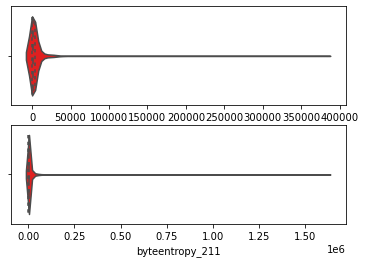

In [82]:
dist_plotter('byteentropy_211')

## Undersampling

Since only 5% of entries are malware, we want a similar 50/50 split between malware and not malware.

In [9]:
majority = df1[df1.category==0] # Majority class
minority = df1[df1.category==1] # Minority class

In [10]:
majority_undersampled = resample(majority, replace=False, n_samples=900) # Randomly selects 900 records from majority to match minority class size
# New downsampled dataset
df_undersampled = pd.concat([majority_undersampled, minority])  # Minority class + sample of 900 from majority
df_undersampled.category.value_counts()

0    900
1    900
Name: category, dtype: int64

In [11]:
df = df_undersampled #make it a new df

In [12]:
X = df.drop('category', axis=1) #X is everything but the 'category' col

In [13]:
y = df['category'] #y is just the target column

In [14]:
X = X._get_numeric_data() #drop all nonnumeric ones (for now?)

In [15]:
print(X.shape, y.shape) #sanity check arrays

(1800, 693) (1800,)


## Feature Selection with ANOVA

Ideally should have selected features after heatmaps/correlation plots/distributions etc but skipped all that for now.

This is automatic but more of a "black box".

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #train test split 80/20

In [ ]:
fs = SelectKBest(score_func=f_classif, k=600) #THIS K IS HOW MANY FEATURES YOU WANT
fs.fit(X_train, y_train)
mask = fs.get_support()
new_features = X_train.columns[mask]

In [18]:
X_train_fs = X_train[new_features]
X_test_fs = X_test[new_features]

In [19]:
# for i in range(len(fs.scores_[:10])):
#     print('Feature %d: %f' % (i, fs.scores_[i]))
# # plot the scores
#     plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
#     plt.show()

Now we can use X_train_fs and X_test_fs in place of X_train and X_test.

In [20]:
print(X_train_fs.shape, X_test_fs.shape)

(1440, 600) (360, 600)


In [21]:
print(y_train.shape, y_test.shape)

(1440,) (360,)


## Modeling

This function basically fits a specified model and outputs it's f1_score as well as ROC curve, can add more graphs/plots to it as well.

In [22]:
def modeler(model):
    model.fit(X_train_fs, y_train) #fit specified model
    y_pred = model.predict(X_test_fs) #predict on test set
    f1 = f1_score(y_test, y_pred) #get f1 score
    print('F1 Score:', f1)
    print(metrics.confusion_matrix(y_test, y_pred))
    
    #this plots the ROC curve, play around iwth it
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

F1 Score: 0.6584615384615384
[[142  32]
 [ 79 107]]


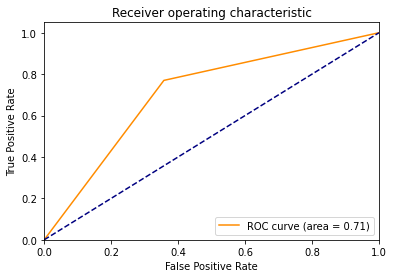

In [23]:
lr = LogisticRegression()
modeler(lr)

F1 Score: 0.906166219839142
[[156  18]
 [ 17 169]]


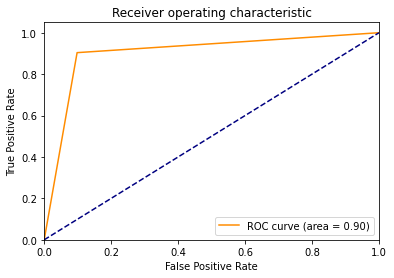

In [24]:
lgbm = lgb.LGBMClassifier()
modeler(lgbm)

[07:37:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score: 0.888888888888889
[[155  19]
 [ 22 164]]


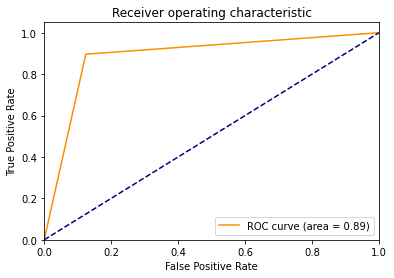

In [25]:
xgbc = xgb.XGBClassifier()
modeler(xgbc)

F1 Score: 0.8672086720867209
[[151  23]
 [ 26 160]]


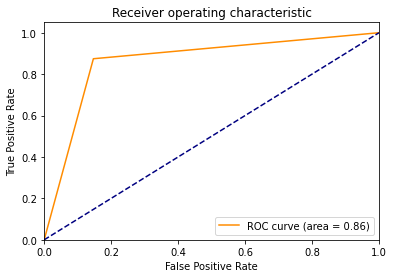

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
modeler(rf)

F1 Score: 0.6802218114602587
[[  3 171]
 [  2 184]]


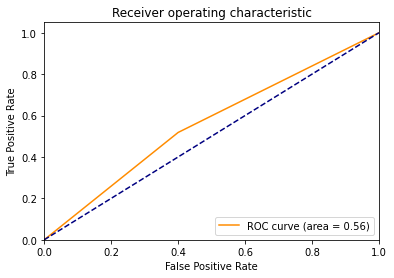

In [27]:
from sklearn.svm import SVC
svm = SVC()
modeler(svm)

F1 Score: 0.7865168539325843
[[144  30]
 [ 46 140]]


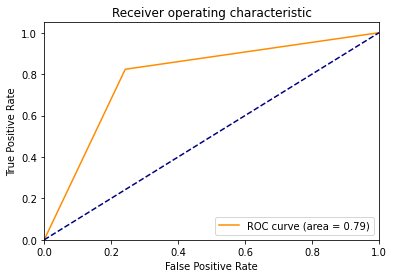

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
modeler(knn)

F1 Score: 0.8191489361702128
[[138  36]
 [ 32 154]]


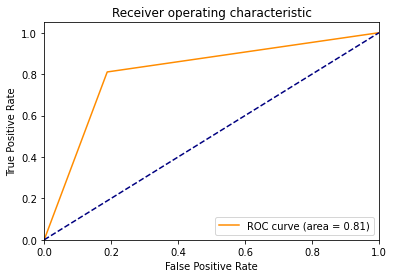

In [29]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
modeler(dt)

Best ones seem to be LGBM and XGB. Ideal ROC graph looks hugs the top left corner.

## Hyperparameter Optimization

Time to tune with Hyperopt.
(Scaling/normalizing isn't needed for gradient boosted decision trees so skip it)

# EVERYONE CAN TRY OPTIMIZING WITH DIFFERENT HYPERPARAMETERS LIKE IN THE COMMENTED OUT LINES, check the user docs for more parameters

In [30]:
#hyperparameter domain to search over
hyperparam_space = {
    'num_leaves': hp.choice('num_leaves', np.arange(30, 250, 1)),
    'learning_rate': hp.quniform('learning_rate', 0, 0.3, 0.01),
#     'min_gain_to_split': hp.quniform('min_gain_to_split', 0, 15, 0.1),
#     'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(200, 10000, 100))
#     lambda: L2 regularization (Ridge)
#     alpha: L1 regularization (Lasso)
}

Following code takes a couple minutes to run:

In [31]:
def score(params): #function to train and test different hyperparams
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_fs, y_train, early_stopping_rounds=20,
             eval_set=[(X_train_fs, y_train), (X_test_fs, y_test)])
#     y_pred = model.predict(X_test_fs)
#     score = mean_squared_error(y_test, y_pred)
    score = -cross_val_score(model, X_train_fs, y_train, cv=10, scoring='roc_auc').mean()
    print(score)
    return score
            
def optimize(trials, space): #fmin is the main library function
    best = fmin(score, space, algo=tpe.suggest, max_evals=10)
    return best
            
trials = Trials() #database that store completed hyperparameters and score
best_params = optimize(trials, hyperparam_space) #calls fmin

#finds best hyperparameters
# space_eval(hyperparam_space, best_params)

[1]	training's binary_logloss: 0.633168	valid_1's binary_logloss: 0.647318                            
Training until validation scores don't improve for 20 rounds                                          
[2]	training's binary_logloss: 0.582878	valid_1's binary_logloss: 0.603735                            
[3]	training's binary_logloss: 0.538647	valid_1's binary_logloss: 0.571732                            
[4]	training's binary_logloss: 0.49983	valid_1's binary_logloss: 0.545291                             
[5]	training's binary_logloss: 0.466758	valid_1's binary_logloss: 0.51937                             
[6]	training's binary_logloss: 0.434994	valid_1's binary_logloss: 0.499087                            
[7]	training's binary_logloss: 0.406198	valid_1's binary_logloss: 0.480253                            
[8]	training's binary_logloss: 0.382123	valid_1's binary_logloss: 0.464093                            
[9]	training's binary_logloss: 0.358162	valid_1's binary_logloss: 0.44827

[4]	training's binary_logloss: 0.402043	valid_1's binary_logloss: 0.473459                            
[5]	training's binary_logloss: 0.360786	valid_1's binary_logloss: 0.449021                            
[6]	training's binary_logloss: 0.324215	valid_1's binary_logloss: 0.418339                            
[7]	training's binary_logloss: 0.293211	valid_1's binary_logloss: 0.403127                            
[8]	training's binary_logloss: 0.265927	valid_1's binary_logloss: 0.382065                            
[9]	training's binary_logloss: 0.24069	valid_1's binary_logloss: 0.366533                             
[10]	training's binary_logloss: 0.217146	valid_1's binary_logloss: 0.354                              
[11]	training's binary_logloss: 0.199061	valid_1's binary_logloss: 0.346734                           
[12]	training's binary_logloss: 0.181372	valid_1's binary_logloss: 0.333429                           
[13]	training's binary_logloss: 0.165019	valid_1's binary_logloss: 0.3200

[28]	training's binary_logloss: 0.0460493	valid_1's binary_logloss: 0.283623                          
[29]	training's binary_logloss: 0.0425585	valid_1's binary_logloss: 0.28079                           
[30]	training's binary_logloss: 0.0387707	valid_1's binary_logloss: 0.282168                          
[31]	training's binary_logloss: 0.0357501	valid_1's binary_logloss: 0.283039                          
[32]	training's binary_logloss: 0.0326404	valid_1's binary_logloss: 0.285367                          
[33]	training's binary_logloss: 0.0298797	valid_1's binary_logloss: 0.283769                          
[34]	training's binary_logloss: 0.027644	valid_1's binary_logloss: 0.284808                           
[35]	training's binary_logloss: 0.0254244	valid_1's binary_logloss: 0.28402                           
[36]	training's binary_logloss: 0.0234238	valid_1's binary_logloss: 0.284934                          
[37]	training's binary_logloss: 0.0215635	valid_1's binary_logloss: 0.286

[5]	training's binary_logloss: 0.266153	valid_1's binary_logloss: 0.383839                            
[6]	training's binary_logloss: 0.229151	valid_1's binary_logloss: 0.371635                            
[7]	training's binary_logloss: 0.197193	valid_1's binary_logloss: 0.35404                             
[8]	training's binary_logloss: 0.170686	valid_1's binary_logloss: 0.342839                            
[9]	training's binary_logloss: 0.146053	valid_1's binary_logloss: 0.330032                            
[10]	training's binary_logloss: 0.126932	valid_1's binary_logloss: 0.325161                           
[11]	training's binary_logloss: 0.108709	valid_1's binary_logloss: 0.314395                           
[12]	training's binary_logloss: 0.0937296	valid_1's binary_logloss: 0.304367                          
[13]	training's binary_logloss: 0.0809669	valid_1's binary_logloss: 0.298842                          
[14]	training's binary_logloss: 0.068385	valid_1's binary_logloss: 0.2937

[41]	training's binary_logloss: 0.0470092	valid_1's binary_logloss: 0.28874                           
[42]	training's binary_logloss: 0.0441678	valid_1's binary_logloss: 0.286638                          
[43]	training's binary_logloss: 0.0416686	valid_1's binary_logloss: 0.285634                          
[44]	training's binary_logloss: 0.0394619	valid_1's binary_logloss: 0.286485                          
[45]	training's binary_logloss: 0.0371118	valid_1's binary_logloss: 0.286266                          
[46]	training's binary_logloss: 0.0350315	valid_1's binary_logloss: 0.286966                          
[47]	training's binary_logloss: 0.0329401	valid_1's binary_logloss: 0.287515                          
[48]	training's binary_logloss: 0.0311585	valid_1's binary_logloss: 0.288035                          
[49]	training's binary_logloss: 0.0294126	valid_1's binary_logloss: 0.288458                          
[50]	training's binary_logloss: 0.027705	valid_1's binary_logloss: 0.2893

[53]	training's binary_logloss: 0.0234041	valid_1's binary_logloss: 0.281938                          
[54]	training's binary_logloss: 0.0220868	valid_1's binary_logloss: 0.282864                          
[55]	training's binary_logloss: 0.0208509	valid_1's binary_logloss: 0.284337                          
[56]	training's binary_logloss: 0.0197733	valid_1's binary_logloss: 0.285888                          
[57]	training's binary_logloss: 0.0186459	valid_1's binary_logloss: 0.287779                          
[58]	training's binary_logloss: 0.0175711	valid_1's binary_logloss: 0.289835                          
[59]	training's binary_logloss: 0.0166299	valid_1's binary_logloss: 0.289811                          
[60]	training's binary_logloss: 0.0157214	valid_1's binary_logloss: 0.291068                          
[61]	training's binary_logloss: 0.0148547	valid_1's binary_logloss: 0.292299                          
[62]	training's binary_logloss: 0.0139573	valid_1's binary_logloss: 0.293

[10]	training's binary_logloss: 0.11801	valid_1's binary_logloss: 0.324531                            
[11]	training's binary_logloss: 0.0997249	valid_1's binary_logloss: 0.316733                          
[12]	training's binary_logloss: 0.0862279	valid_1's binary_logloss: 0.310726                          
[13]	training's binary_logloss: 0.0735991	valid_1's binary_logloss: 0.310516                          
[14]	training's binary_logloss: 0.0623161	valid_1's binary_logloss: 0.306909                          
[15]	training's binary_logloss: 0.0532168	valid_1's binary_logloss: 0.3048                            
[16]	training's binary_logloss: 0.0456268	valid_1's binary_logloss: 0.306165                          
[17]	training's binary_logloss: 0.0394279	valid_1's binary_logloss: 0.310713                          
[18]	training's binary_logloss: 0.03363	valid_1's binary_logloss: 0.310626                            
[19]	training's binary_logloss: 0.0288366	valid_1's binary_logloss: 0.306

In [32]:
best_params

{'learning_rate': 0.29, 'num_leaves': 74}

In [33]:
lgbm_model = lgb.LGBMClassifier(**best_params)
lgbm_model.fit(X_train_fs, y_train)
preds = [pred[1] for pred in lgbm_model.predict_proba(X_test_fs)]
score = roc_auc_score(y_test, preds, average='weighted')
print('auc_roc score on test data: ', score)

auc_roc score on test data:  0.9597701149425288


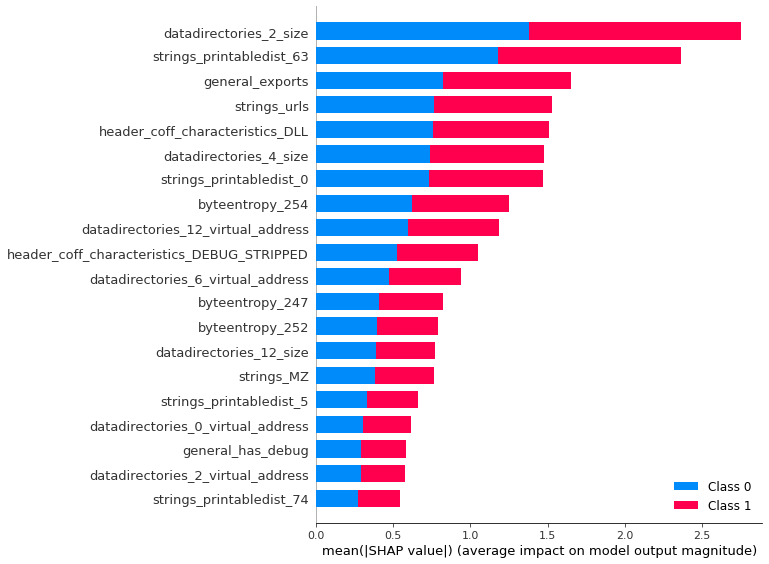

In [34]:
shap_values = shap.TreeExplainer(lgbm_model).shap_values(X_test_fs)
shap.summary_plot(shap_values, X_test_fs)

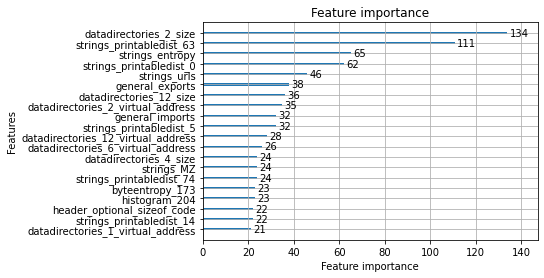

<Figure size 1800x864 with 0 Axes>

In [35]:
lgb.plot_importance(lgbm_model, max_num_features=20)
plt.figure(figsize=(25, 12))
plt.show()

In [91]:
y_pred = lgbm_model.predict(X_test_fs)

In [92]:
f1=f1_score(y_test, y_pred) #get f1 score
print('F1 Score:', f1)

F1 Score: 0.9071618037135278


In [93]:
print(metrics.confusion_matrix(y_test, y_pred))

[[154  20]
 [ 15 171]]


In [36]:
#hyperparameter domain to search over
hyperparam_space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 10, 1, dtype=int)), #larger values = overfitting
    'n_estimators': hp.choice('n_estimators', np.arange(1, 100, 1, dtype=int)), #larger values = overfitting
    'learning_rate': hp.quniform('learning_rate', 0, 1, 0.01), #aka eta = step size shrinkage to prevent overfitting
    'gamma': hp.quniform('gamma', 0, 1, 0.1), #gamma: min loss reduction to partition leaf nodes (for overfitting)
#     lambda: L2 regularization (Ridge)
#     alpha: L1 regularization (Lasso)
}

In [37]:
def xgb_score(params): #function to train and test different hyperparams
    model = xgb.XGBClassifier(**params, eval_metric='logloss')
    model.fit(X_train_fs, y_train, early_stopping_rounds=20,
             eval_set=[(X_train_fs, y_train), (X_test_fs, y_test)])
    score = -cross_val_score(model, X_train_fs, y_train, cv=10, scoring='roc_auc').mean()
    print(score)
    return {'loss': score, 'status': STATUS_OK}
            
def xgb_optimize(trials, space): #fmin is the main library function
    best = fmin(xgb_score, space, algo=tpe.suggest, max_evals=10)
    return best
            
trials = Trials() #database that store completed hyperparameters and score
best_xgb_params = xgb_optimize(trials, hyperparam_space) #calls fmin

[0]	validation_0-logloss:0.29288	validation_1-logloss:0.45000                                         
[1]	validation_0-logloss:0.16420	validation_1-logloss:0.37676                                         
[2]	validation_0-logloss:0.10455	validation_1-logloss:0.35756                                         
[3]	validation_0-logloss:0.07387	validation_1-logloss:0.35657                                         
[4]	validation_0-logloss:0.05650	validation_1-logloss:0.33814                                         
[5]	validation_0-logloss:0.04209	validation_1-logloss:0.33868                                         
[6]	validation_0-logloss:0.03336	validation_1-logloss:0.34140                                         
[7]	validation_0-logloss:0.02854	validation_1-logloss:0.33627                                         
[8]	validation_0-logloss:0.02372	validation_1-logloss:0.34236                                         
[9]	validation_0-logloss:0.02046	validation_1-logloss:0.34326            

[46]	validation_0-logloss:0.14595	validation_1-logloss:0.29435                                        
[47]	validation_0-logloss:0.14320	validation_1-logloss:0.29487                                        
[48]	validation_0-logloss:0.14066	validation_1-logloss:0.29561                                        
[49]	validation_0-logloss:0.13868	validation_1-logloss:0.29522                                        
[50]	validation_0-logloss:0.13697	validation_1-logloss:0.29668                                        
[51]	validation_0-logloss:0.13457	validation_1-logloss:0.29553                                        
[52]	validation_0-logloss:0.13266	validation_1-logloss:0.29545                                        
[53]	validation_0-logloss:0.13073	validation_1-logloss:0.29372                                        
[54]	validation_0-logloss:0.12905	validation_1-logloss:0.29276                                        
[55]	validation_0-logloss:0.12659	validation_1-logloss:0.29150           

[33]	validation_0-logloss:0.24606	validation_1-logloss:0.32587                                        
[34]	validation_0-logloss:0.24218	validation_1-logloss:0.32259                                        
[35]	validation_0-logloss:0.23877	validation_1-logloss:0.32098                                        
[36]	validation_0-logloss:0.23632	validation_1-logloss:0.31891                                        
[37]	validation_0-logloss:0.23304	validation_1-logloss:0.31639                                        
[38]	validation_0-logloss:0.23107	validation_1-logloss:0.31551                                        
[39]	validation_0-logloss:0.22748	validation_1-logloss:0.31497                                        
[40]	validation_0-logloss:0.22409	validation_1-logloss:0.31336                                        
[41]	validation_0-logloss:0.22146	validation_1-logloss:0.31253                                        
[42]	validation_0-logloss:0.21938	validation_1-logloss:0.31104           

[4]	validation_0-logloss:0.06616	validation_1-logloss:0.32003                                         
[5]	validation_0-logloss:0.04786	validation_1-logloss:0.33970                                         
[6]	validation_0-logloss:0.03677	validation_1-logloss:0.34251                                         
[7]	validation_0-logloss:0.02978	validation_1-logloss:0.35818                                         
[8]	validation_0-logloss:0.02577	validation_1-logloss:0.36073                                         
[9]	validation_0-logloss:0.02233	validation_1-logloss:0.37904                                         
[10]	validation_0-logloss:0.01930	validation_1-logloss:0.36549                                        
[11]	validation_0-logloss:0.01694	validation_1-logloss:0.37165                                        
[12]	validation_0-logloss:0.01597	validation_1-logloss:0.37863                                        
[13]	validation_0-logloss:0.01469	validation_1-logloss:0.37926           

[23]	validation_0-logloss:0.24704	validation_1-logloss:0.30404                                        
[24]	validation_0-logloss:0.24452	validation_1-logloss:0.30313                                        
[25]	validation_0-logloss:0.24139	validation_1-logloss:0.29984                                        
[26]	validation_0-logloss:0.23885	validation_1-logloss:0.29319                                        
[27]	validation_0-logloss:0.23641	validation_1-logloss:0.29556                                        
-0.9407345048538314                                                                                   
100%|██████████████████████████████| 10/10 [03:22<00:00, 20.28s/trial, best loss: -0.9574029337959093]


In [38]:
best_xgb_params

{'gamma': 0.1, 'learning_rate': 0.34, 'max_depth': 1, 'n_estimators': 59}

In [39]:
xgb_model = xgb.XGBClassifier(**best_xgb_params, eval_metric='logloss')
xgb_model.fit(X_train_fs, y_train)
preds = [pred[1] for pred in xgb_model.predict_proba(X_test_fs)]
score = roc_auc_score(y_test, preds, average='weighted')
print('auc_roc score on test data: ', score)

auc_roc score on test data:  0.9469008775182302


In [87]:
y_pred = xgb_model.predict(X_test_fs)

In [89]:
f1=f1_score(y_test, y_pred) #get f1 score
print('F1 Score:', f1)

F1 Score: 0.8787061994609164


In [90]:
print(metrics.confusion_matrix(y_test, y_pred))

[[152  22]
 [ 23 163]]


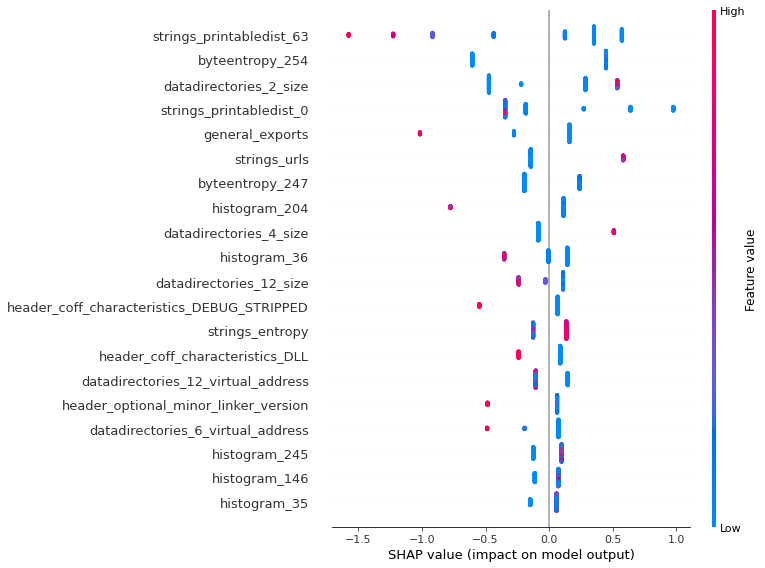

In [40]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_test_fs)
shap.summary_plot(shap_values, X_test_fs)

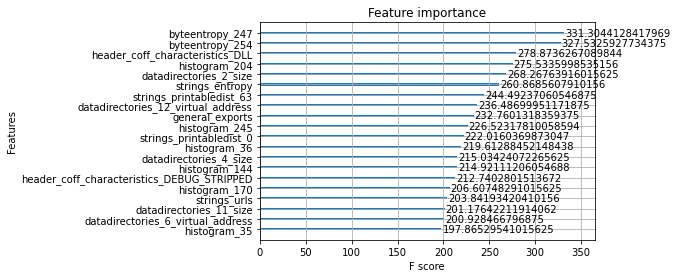

<Figure size 1800x864 with 0 Axes>

In [41]:
xgb.plot_importance(xgb_model, importance_type='cover', max_num_features=20)
plt.figure(figsize=(25, 12))
plt.show()

## Conclusions

## Visualizations should include the above ROC plots, SHAP plots, as well as the built in feature importance plots.

# scrap the below in final version

### Anomaly Detection Approach??

In [42]:
df1.shape #go back to original dataset

(18000, 714)

In [43]:
df1 = df1._get_numeric_data() #drop nonnumeric columns

#### Isolation Forest

Setting contamination rate to 5% as seen in original data, using 200 estimators.

In [44]:
iso = IsolationForest(n_estimators=200, max_samples='auto', contamination=0.05)
new_df = df1.drop(columns=['category'])
iso.fit(new_df)
new_df['anomaly_score'] = iso.predict(new_df)
new_df[new_df['anomaly_score'] == -1].shape

(900, 694)

As expected, found 900 "outliers" (in our case malware).

In [45]:
iso_df = pd.concat([new_df, df1['category']], axis=1) #join the anomaly prediction with og data
iso_df.head(10)

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,...,datadirectories_12_size,datadirectories_12_virtual_address,datadirectories_13_size,datadirectories_13_virtual_address,datadirectories_14_size,datadirectories_14_virtual_address,datadirectories_15_size,datadirectories_15_virtual_address,anomaly_score,category
0,127242,9185,3818,3127,13300,1594,1781,1493,9938,1006,...,620,11711244,0,0,0,0,0,0,1,0
1,36152,2617,4120,876,1711,755,672,521,2278,325,...,340,131072,0,0,0,0,0,0,1,0
2,39986,7112,7953,6604,6542,6441,5869,6422,6224,6017,...,588,123728,0,0,0,0,0,0,1,0
3,253873,32714,22629,17500,15355,6691,10881,4258,11992,3513,...,216,282920,0,0,0,0,0,0,1,0
4,12464,1020,502,264,1918,218,262,91,846,78,...,0,0,0,0,0,0,0,0,1,0
5,17889,1281,868,642,914,138,311,148,433,82,...,0,0,0,0,0,0,0,0,1,0
6,224255,28215,12691,13046,21264,4115,3790,3590,11766,1889,...,408,1188328,0,0,0,0,0,0,1,0
7,14195,1054,778,1068,291,653,251,249,338,164,...,0,0,0,0,0,0,0,0,1,0
8,48208,3288,1441,2611,4938,313,266,635,2104,231,...,1284,230880,0,0,0,0,0,0,1,0
9,370224,37570,24575,18127,40687,15614,12405,11777,24099,5331,...,0,0,0,0,0,0,0,0,1,0


In [46]:
iso_df.groupby('anomaly_score').size() #sanity check

anomaly_score
-1      900
 1    17100
dtype: int64

In [47]:
iso_df['anomaly'] = "" #add new empty column to switch out -1 to 1 and 1 to 0

In [48]:
iso_df.loc[iso_df.anomaly_score == -1, "anomaly"] = 1
iso_df.loc[iso_df.anomaly_score == 1, "anomaly"] = 0

In [49]:
print(iso_df.groupby('anomaly').size(), iso_df.groupby('category').size())

anomaly
0    17100
1      900
dtype: int64 category
0    17100
1      900
dtype: int64


In [50]:
iso_df.head(5)

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,...,datadirectories_12_virtual_address,datadirectories_13_size,datadirectories_13_virtual_address,datadirectories_14_size,datadirectories_14_virtual_address,datadirectories_15_size,datadirectories_15_virtual_address,anomaly_score,category,anomaly
0,127242,9185,3818,3127,13300,1594,1781,1493,9938,1006,...,11711244,0,0,0,0,0,0,1,0,0
1,36152,2617,4120,876,1711,755,672,521,2278,325,...,131072,0,0,0,0,0,0,1,0,0
2,39986,7112,7953,6604,6542,6441,5869,6422,6224,6017,...,123728,0,0,0,0,0,0,1,0,0
3,253873,32714,22629,17500,15355,6691,10881,4258,11992,3513,...,282920,0,0,0,0,0,0,1,0,0
4,12464,1020,502,264,1918,218,262,91,846,78,...,0,0,0,0,0,0,0,1,0,0


Calculate f1 score between new anomaly column and given category column.

In [51]:
f1_score(list(iso_df['category']), list(iso_df['anomaly']))

0.008888888888888889

### what happened???